In [2]:
import pandas as pd
import numpy as np
from collections import OrderedDict

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn import metrics, cross_validation
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Import the files
aisles_df = pd.read_csv('aisles.csv')
products_df = pd.read_csv('products.csv')
orders_df = pd.read_csv('orders.csv')
order_products_prior_df = pd.read_csv('order_products__prior.csv')
departments_df = pd.read_csv('departments.csv')
order_products_train_df = pd.read_csv('order_products__train.csv')

# Preliminary analysis and modeling

In [3]:
order_products_train_df = order_products_train_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')
order_products_prior_df = order_products_prior_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')

In [4]:
user_product_df = (order_products_prior_df.groupby(['product_id','user_id'],as_index=False) 
                                          .agg({'order_id':'count'}) 
                                          .rename(columns={'order_id':'user_product_total_orders'}))

train_ids = order_products_train_df['user_id'].unique() 
df_X = user_product_df[user_product_df['user_id'].isin(train_ids)]
df_X.head()

,product_id,user_id,user_product_total_orders
0,1,138,2
1,1,709,1
3,1,777,1
6,1,1052,2
9,1,1494,3


In [5]:
train_carts = (order_products_train_df.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

df_X = df_X.merge(train_carts, on='user_id')
df_X['in_cart'] = (df_X.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart
0,1,138,2,{42475},0
1,907,138,2,{42475},0
2,1000,138,1,{42475},0
3,3265,138,1,{42475},0
4,4913,138,1,{42475},0


In [6]:
#Here I see class imbalance
df_X['in_cart'].value_counts()

0    7645837
1     828824
Name: in_cart, dtype: int64

## Product Features

In [7]:
prod_features = ['product_total_orders','product_avg_add_to_cart_order']

prod_features_df = (order_products_prior_df.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))
prod_features_df.columns = ['product_id'] + prod_features
prod_features_df.head()

,product_id,product_total_orders,product_avg_add_to_cart_order
0,1,1852,5.801836
1,2,90,9.888889
2,3,277,6.415162
3,4,329,9.507599
4,5,15,6.466667


In [8]:
df_X = df_X.merge(prod_features_df, on='product_id')

#note that dropping rows with NA product_avg_days_since_prior_order is likely a naive choice 
df_X = df_X.dropna()
df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order
0,1,138,2,{42475},0,1852,5.801836
1,1,709,1,"{14177, 28577, 37089, 16068, 32005, 45444, 102...",0,1852,5.801836
2,1,777,1,"{43352, 6184, 16797}",0,1852,5.801836
3,1,1052,2,{17207},0,1852,5.801836
4,1,1494,3,{44560},0,1852,5.801836


## User Features

In [9]:
user_features = ['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order']

user_features_df = (order_products_prior_df.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order','mean')])))

user_features_df.columns = ['user_id'] + user_features
user_features_df.head()

,user_id,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,1,10,5.900000,18,20.259259
1,2,14,13.928571,102,15.967033
2,3,12,7.333333,33,11.487179
3,4,5,3.600000,17,15.357143
4,5,4,9.250000,23,14.500000


In [10]:
df_X = df_X.merge(user_features_df, on='user_id')
df_X = df_X.dropna()
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,1,138,2,{42475},0,1852,5.801836,32,4.625,55,10.4


## User-Product Features

In [11]:
user_prod_features = ['user_product_avg_add_to_cart_order']

user_prod_features_df = (order_products_prior_df.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('add_to_cart_order','mean')])))

user_prod_features_df.columns = ['product_id','user_id'] + user_prod_features 
user_prod_features_df.head()

,product_id,user_id,user_product_avg_add_to_cart_order
0,1,138,3.0
1,1,709,20.0
2,1,764,10.5
3,1,777,7.0
4,1,825,2.0


In [12]:
df_X = df_X.merge(user_prod_features_df,on=['user_id','product_id'])
df_X['user_product_order_freq'] = df_X['user_product_total_orders'] / df_X['user_total_orders'] 
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq
0,1,138,2,{42475},0,1852,5.801836,32,4.625,55,10.4,3.0,0.0625


# Adding more features and complicating the model

## Product features

In [13]:
#3 product features: average day of week when ordered, average day of the week, and average days since prior order
prod_features = ['product_avg_order_dow', 'product_avg_order_hour_of_day', 'product_avg_days_since_prior_order']

prod_features_df = (order_products_prior_df.groupby(['product_id'], as_index=False)
                                     .agg(OrderedDict(
                                     [('order_dow','mean'),
                                      ('order_hour_of_day', 'mean'),
                                      ('days_since_prior_order', 'mean')])))

prod_features_df.columns = ['product_id'] + prod_features
prod_features_df.head()

,product_id,product_avg_order_dow,product_avg_order_hour_of_day,product_avg_days_since_prior_order
0,1,2.776458,13.238121,10.432725
1,2,2.922222,13.277778,10.482759
2,3,2.736462,12.104693,10.565385
3,4,2.683891,13.714286,14.686207
4,5,2.733333,10.666667,12.428571


In [14]:
df_X = df_X.merge(prod_features_df, on='product_id')
df_X = df_X.dropna()
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,product_avg_order_dow,product_avg_order_hour_of_day,product_avg_days_since_prior_order
0,1,138,2,{42475},0,1852,5.801836,32,4.625,55,10.4,3.0,0.0625,2.776458,13.238121,10.432725


## User Features

In [15]:
user_features = ['user_avg_order_dow','user_avg_order_hour_of_day']

user_features_df = (order_products_prior_df.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_dow','mean'),
                                                    ('order_hour_of_day','mean')])))

user_features_df.columns = ['user_id'] + user_features
user_features_df.head()

,user_id,user_avg_order_dow,user_avg_order_hour_of_day
0,1,2.644068,10.542373
1,2,2.005128,10.441026
2,3,1.011364,16.352273
3,4,4.722222,13.111111
4,5,1.621622,15.729730


In [16]:
df_X = df_X.merge(user_features_df, on='user_id')
df_X = df_X.dropna()
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,product_avg_order_dow,product_avg_order_hour_of_day,product_avg_days_since_prior_order,user_avg_order_dow,user_avg_order_hour_of_day
0,1,138,2,{42475},0,1852,5.801836,32,4.625,55,10.4,3.0,0.0625,2.776458,13.238121,10.432725,3.040541,12.689189


## User-Product Features

In [17]:
user_prod_features = ['user_product_avg_days_since_prior_order',
                      'user_product_avg_order_dow',
                      'user_product_avg_order_hour_of_day']

user_prod_features_df = (order_products_prior_df.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('days_since_prior_order','mean'),
                                                     ('order_dow','mean'),
                                                     ('order_hour_of_day','mean')])))

user_prod_features_df.columns = ['product_id','user_id'] + user_prod_features 
user_prod_features_df.head()

,product_id,user_id,user_product_avg_days_since_prior_order,user_product_avg_order_dow,user_product_avg_order_hour_of_day
0,1,138,11.5,6.0,14.0
1,1,709,6.0,0.0,21.0
2,1,764,9.0,3.5,15.0
3,1,777,26.0,1.0,7.0
4,1,825,30.0,2.0,14.0


In [18]:
df_X = df_X.merge(user_prod_features_df, on=['user_id', 'product_id'])
df_X = df_X.dropna()
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,...,user_product_avg_add_to_cart_order,user_product_order_freq,product_avg_order_dow,product_avg_order_hour_of_day,product_avg_days_since_prior_order,user_avg_order_dow,user_avg_order_hour_of_day,user_product_avg_days_since_prior_order,user_product_avg_order_dow,user_product_avg_order_hour_of_day
0,1,138,2,{42475},0,1852,5.801836,32,4.625,55,...,3.0,0.0625,2.776458,13.238121,10.432725,3.040541,12.689189,11.5,6.0,14.0


## Deltas

In [19]:
#Create delta columns to compare how users perform against averages
df_X['product_total_orders_delta_per_user'] = df_X['product_total_orders'] - df_X['user_product_total_orders']

df_X['product_avg_add_to_cart_order_delta_per_user'] = df_X['product_avg_add_to_cart_order'] - \
                                                            df_X['user_product_avg_add_to_cart_order']

df_X['product_avg_order_dow_per_user'] = df_X['product_avg_order_dow'] - df_X['user_product_avg_order_dow']

df_X['product_avg_order_hour_of_day_per_user'] = df_X['product_avg_order_hour_of_day'] - \
                                                            df_X['user_product_avg_order_hour_of_day']

df_X['product_avg_days_since_prior_order_per_user'] = df_X['product_avg_days_since_prior_order'] - \
                                                            df_X['user_product_avg_days_since_prior_order']

## Expand dummies for department names

In [20]:
temp = products_df.merge(departments_df, on = 'department_id')
temp = temp[['product_id', 'department']]
temp.head()

,product_id,department
0,1,snacks
1,16,snacks
2,25,snacks
3,32,snacks
4,41,snacks


In [21]:
df_X = df_X.merge(temp, on = 'product_id')
df_X = df_X.dropna()
df_X = pd.concat([df_X, pd.get_dummies(df_X['department'])], axis=1)
del df_X['department']

# Use best model

In [22]:
np.random.seed(29)
total_users = df_X['user_id'].unique() 
test_users = np.random.choice(total_users, size=int(total_users.shape[0] * .30), replace=False)

test_user_sets = []
length = len(test_users)
cv = 10

for x in range (0, cv):
    start = int(x/cv*length)
    finish = int((x+1)/cv*length)
    test_user_sets.append(test_users[start:finish])
    
cv_f1_scores = []
cv_f1_scores_balanced = []
cv_f1_scores_10fit = []

for test_user_set in test_user_sets:
    df_X_tr, df_X_te = df_X[~df_X['user_id'].isin(test_user_set)], df_X[df_X['user_id'].isin(test_user_set)] 

    y_tr, y_te = df_X_tr['in_cart'], df_X_te['in_cart']
    X_tr, X_te = df_X_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
             df_X_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
        
    scaler = MinMaxScaler()
    X_tr = pd.DataFrame(scaler.fit_transform(X_tr), columns=X_tr.columns)
    X_te = pd.DataFrame(scaler.fit_transform(X_te), columns=X_te.columns)
    
    lr = LogisticRegression(C=10000000) 
    lr_balanced = LogisticRegression(class_weight='balanced', C=10000000)
    lr_10x = LogisticRegression(class_weight={1 : 6, 0 : 1}, C=10000000)
    
    lr.fit(X_tr, y_tr)
    cv_f1_scores.append(f1_score(lr.predict(X_te), y_te))

    lr_balanced.fit(X_tr, y_tr)
    cv_f1_scores_balanced.append(f1_score(lr_balanced.predict(X_te), y_te))

    lr_10x.fit(X_tr, y_tr)
    cv_f1_scores_10fit.append(f1_score(lr_10x.predict(X_te), y_te))   

print(np.mean(cv_f1_scores))
print(np.mean(cv_f1_scores_balanced))
print(np.mean(cv_f1_scores_10fit))

df_X_tr, df_X_te = df_X[~df_X['user_id'].isin(test_users)], df_X[df_X['user_id'].isin(test_users)]

y_tr, y_te = df_X_tr['in_cart'], df_X_te['in_cart']
X_tr, X_te = df_X_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
             df_X_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \

lr_10x = LogisticRegression(class_weight={1 : 6, 0 : 1}, C=10000000)
lr_10x.fit(X_tr, y_tr)
f1_score(lr_10x.predict(X_te), y_te)

0.19059893122
0.380791783245
0.384146059261


0.37952099803713157

In [23]:
np.random.seed(43)
total_users = df_X['user_id'].unique() 
test_users = np.random.choice(total_users, size=int(total_users.shape[0] * .20), replace=False)

df_X_tr, df_X_te = df_X[~df_X['user_id'].isin(test_users)], df_X[df_X['user_id'].isin(test_users)]
                        
val_index = np.random.choice(df_X_tr.index, int(len(df_X_tr.index)/4), replace=False)
df_X_val = df_X.loc[val_index]
df_X_tr = df_X.loc[~df_X.index.isin(val_index)]                        

y_tr, y_val, y_te = df_X_tr['in_cart'], df_X_val['in_cart'], df_X_te['in_cart']
X_tr, X_val, X_te = df_X_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
             df_X_val.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
             df_X_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
        
scaler = MinMaxScaler()
X_tr = pd.DataFrame(scaler.fit_transform(X_tr), columns=X_tr.columns)
X_val = pd.DataFrame(scaler.fit_transform(X_val), columns=X_val.columns)
X_te = pd.DataFrame(scaler.fit_transform(X_te), columns=X_te.columns)
    
lr = LogisticRegression(C=10000000) 
lr_balanced = LogisticRegression(class_weight='balanced', C=10000000)
lr_10x = LogisticRegression(class_weight={1 : 6, 0 : 1}, C=10000000)
    
lr.fit(X_tr, y_tr)
cv_f1_score = f1_score(lr.predict(X_val), y_val)

lr_balanced.fit(X_tr, y_tr)
cv_f1_score_balanced = f1_score(lr_balanced.predict(X_val), y_val)

lr_10x.fit(X_tr, y_tr)
cv_f1_score_lr_10x = f1_score(lr_10x.predict(X_val), y_val)  

print(cv_f1_score)
print(cv_f1_score_balanced)
print(cv_f1_score_lr_10x)

df_X_tr, df_X_te = df_X[~df_X['user_id'].isin(test_users)], df_X[df_X['user_id'].isin(test_users)]

y_tr, y_te = df_X_tr['in_cart'], df_X_te['in_cart']
X_tr, X_te = df_X_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
             df_X_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \

lr_10x = LogisticRegression(class_weight={1 : 6, 0 : 1}, C=10000000)
lr_10x.fit(X_tr, y_tr)
f1_score(lr_10x.predict(X_te), y_te)

0.20743518619
0.375943942031
0.394093182989


0.38125348113112795

In [24]:
coefficients = pd.DataFrame(lr_10x.coef_, columns = X_tr.columns)
coefficients = np.exp(coefficients)
coefficients.T

,0
user_product_total_orders,1.156720
product_total_orders,1.075510
product_avg_add_to_cart_order,0.905234
user_total_orders,0.981141
user_avg_cartsize,1.051901
user_total_products,0.994552
user_avg_days_since_prior_order,0.986311
user_product_avg_add_to_cart_order,0.946543
user_product_order_freq,1.250403
product_avg_order_dow,0.965113


Training Data Accuracy: 0.83
Test Data Accuracy:     0.83
[[1248846  193504]
 [  77554   83509]]


Precision:              0.30
Recall:                 0.52


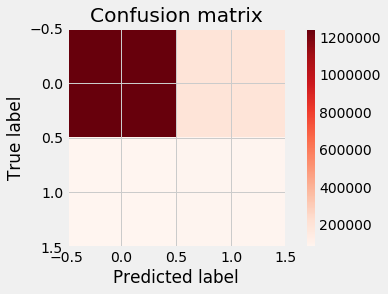

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#y_tr=np.ravel(y_tr)

train_acc=lr_10x.score(X_tr, y_tr)
test_acc=lr_10x.score(X_te, y_te)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))
    
y_true = y_te
y_pred = lr_10x.predict(X_te)


conf = confusion_matrix(y_true, y_pred)
print(conf)

print ('\n')
print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
cm=confusion_matrix(y_true, y_pred, labels=[0, 1])
    
plt.figure()
plot_confusion_matrix(cm)

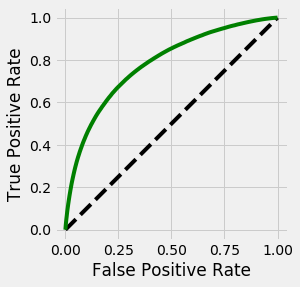

In [26]:
from sklearn.metrics import roc_curve, auc

y_score = lr_10x.predict_proba(X_te)[:,1]

fpr, tpr,_ = roc_curve(y_te, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1], linestyle='--', color = 'black')
plt.plot(fpr, tpr, color = 'green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')